In [50]:
import os
import glob
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
# don't use GPU
tf.config.experimental.set_visible_devices([], 'GPU')

TEST_SIZE=0.1
SEED=1
BATCH_SIZE=64
INPUT_DIR = "./input/"
DATA_DIR = f"{INPUT_DIR}/traffic_Data/DATA/"

tf.random.set_seed(SEED)


In [51]:
labels_df = pd.read_csv(f'{INPUT_DIR}labels.csv')
print(labels_df.sample(10))

#Create a label map
label_map = dict(labels_df.values)

    ClassId                  Name
26       26            keep Right
22       22               Go Left
41       41              Unknown2
19       19  Speed limit (50km/h)
56       56              Unknown7
25       25             keep Left
36       36     Bicycles crossing
55       55              No entry
43       43  Go right or straight
27       27  Roundabout mandatory


In [52]:
image_list = list(Path(DATA_DIR).glob(r'**/*.png'))
labels = list(map(lambda path: os.path.split(os.path.split(path)[0])[1], image_list))

#Create dataframe with path of images and labels
image_series = pd.Series(image_list).astype(str)
labels_series = pd.Series(labels).astype(str)
frame = {'image':image_series, 'label':labels_series}
image_df = pd.DataFrame(frame)
print(image_df.sample(5))

                                          image label
1784    input/traffic_Data/DATA/10/010_0034.png    10
3369     input/traffic_Data/DATA/3/003_0049.png     3
214     input/traffic_Data/DATA/35/035_0072.png    35
3018  input/traffic_Data/DATA/41/041_1_0006.png    41
1854    input/traffic_Data/DATA/26/026_0059.png    26


<AxesSubplot: xlabel='label', ylabel='count images'>

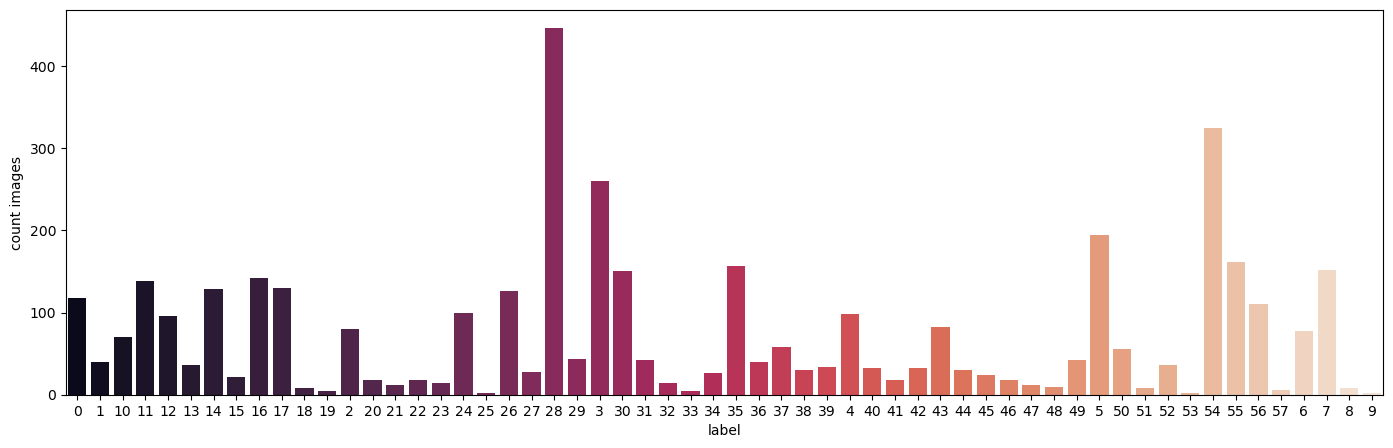

In [53]:
count_labels = image_df.groupby(['label']).size()
plt.figure(figsize=(17,5))
plt.ylabel('count images')
sns.barplot(x=count_labels.index, y=count_labels, palette="rocket")

In [54]:
SPLIT_MINIMUM_COUNT = 10

In [55]:
def split_dataset(df, rate=SPLIT_MINIMUM_COUNT):
  """
  Allocate a  dataset that has at least SPLIT_MINIMUM_COUNT_IMAGES of images
  
  split_df: dataframe for train
  train1_df: dataframe for drop
  """

  count_labels = df.groupby(['label']).size()
  count_labels_df = count_labels.to_frame(name='count_images').reset_index()

  drop_label_list = list(
      count_labels_df['label'].\
      loc[count_labels_df['count_images']<SPLIT_MINIMUM_COUNT]
  )

  drop_df = df.copy()
  split_df = df.copy()

  for index, row in df.iterrows():
    if str(row.label) in drop_label_list:
      split_df = split_df.drop(index)
    else:
      drop_df = drop_df.drop(index)

  return split_df, drop_df

def custom_train_test_split(df):
    """
      Train test split where test_df has minimum 1 image in all labels
    in random split. This need to work model.fit and model.evaluate
    """
  
    labels = df.label.unique()
    test_df = pd.DataFrame()

    for label in labels:
      label_samples = df.loc[df.label==label]
      test_df = test_df.append(label_samples.sample(len(label_samples)//10+1,random_state=SEED))
    
    train_df = df.drop(list(test_df.index), axis=0)
    test_df = test_df.sample(frac=1, random_state=SEED)
    train_df = train_df.sample(frac=1, random_state=SEED)

    return train_df, test_df


In [56]:
train_df, _ = split_dataset(image_df)
#train_df, test_df = custom_train_test_split(split_df)
train, val = custom_train_test_split(train_df)

/var/folders/5s/flbn07vn6l99jj1300j8154h0000gn/T/ipykernel_23049/2612169878.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(label_samples.sample(len(label_samples)//10+1,random_state=SEED))
/var/folders/5s/flbn07vn6l99jj1300j8154h0000gn/T/ipykernel_23049/2612169878.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(label_samples.sample(len(label_samples)//10+1,random_state=SEED))
/var/folders/5s/flbn07vn6l99jj1300j8154h0000gn/T/ipykernel_23049/2612169878.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(label_samples.sample(len(label_samples)//10+1,random_state=SEED))
/var/folders/5s/flbn07vn6l99jj1300j8154h0000gn/T/ipykernel_23049/26121698

In [57]:
train_labels = train_df.groupby(['label']).size()
NUM_CLASSES = len(train_labels)

In [58]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range = 45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='constant',
    shear_range=0.1,
    zoom_range=0.15
)

In [59]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val,
    x_col='image',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

Found 4126 validated image filenames belonging to 49 classes.
Found 443 validated image filenames belonging to 49 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


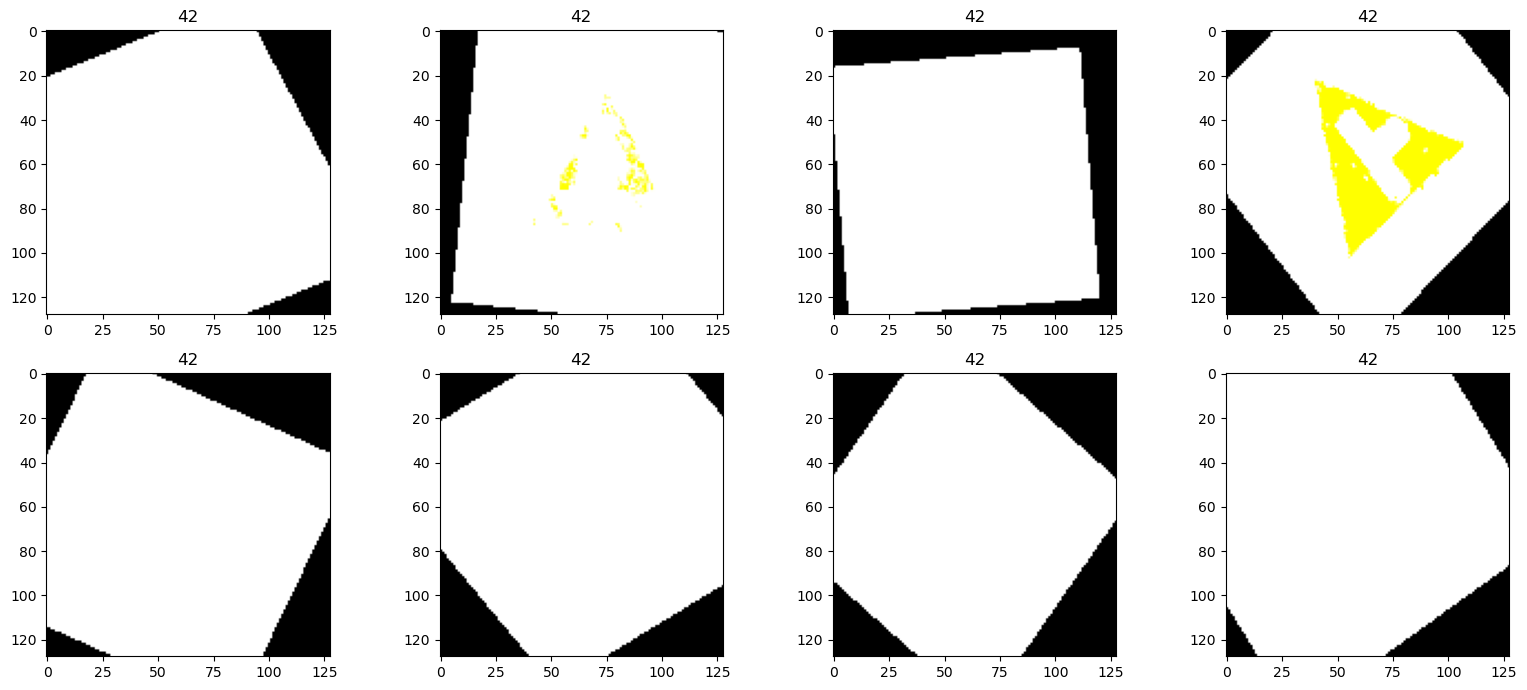

In [60]:
#plot images
fig, axes = plt.subplots(2,4, figsize=(16, 7))
for idx, ax in enumerate(axes.flat):
	image, label = train_images[idx]
	ax.imshow(image[0])
	ax.set_title(train_images.labels[idx])
plt.tight_layout()
plt.show()

In [61]:
#create model
def create_model(input_shape=(128,128,3)):
  """
  load EfficientNet without last layer and 
  add Dense and ouput Dense with NUM_CLASSES units

  """
  inputs = tf.keras.layers.Input(input_shape)

  base_model = tf.keras.applications.EfficientNetB0(
      include_top=False,
      weights='imagenet',
      pooling='avg'
  )
  base_model.trainable = False
  
  x = base_model(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  #x = tf.keras.layers.Dropout(0.2)(x)
  #x = tf.keras.layers.Dense(256, activation='relu')(x)
  outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

  return tf.keras.models.Model(inputs, outputs)

In [62]:
model = create_model()

In [63]:
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['acc'],
)

In [64]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_images,
    epochs=20,
    validation_data=val_images,
    callbacks=[callback]
)

Epoch 1/20
65/65 [==============================] - 22s 305ms/step - loss: 1.0439 - acc: 0.7271 - val_loss: 0.8503 - val_acc: 0.8600
Epoch 2/20
65/65 [==============================] - 19s 287ms/step - loss: 0.2922 - acc: 0.9115 - val_loss: 0.4397 - val_acc: 0.9278
Epoch 3/20
65/65 [==============================] - 19s 296ms/step - loss: 0.1820 - acc: 0.9457 - val_loss: 0.2097 - val_acc: 0.9594
Epoch 4/20
65/65 [==============================] - 20s 302ms/step - loss: 0.1532 - acc: 0.9496 - val_loss: 0.1226 - val_acc: 0.9774
Epoch 5/20
65/65 [==============================] - 24s 361ms/step - loss: 0.1269 - acc: 0.9588 - val_loss: 0.1164 - val_acc: 0.9707
Epoch 6/20
65/65 [==============================] - 22s 338ms/step - loss: 0.1223 - acc: 0.9603 - val_loss: 0.0573 - val_acc: 0.9865
Epoch 7/20
65/65 [==============================] - 23s 354ms/step - loss: 0.1092 - acc: 0.9619 - val_loss: 0.0470 - val_acc: 0.9865
Epoch 8/20
65/65 [==============================] - 24s 360ms/step - 

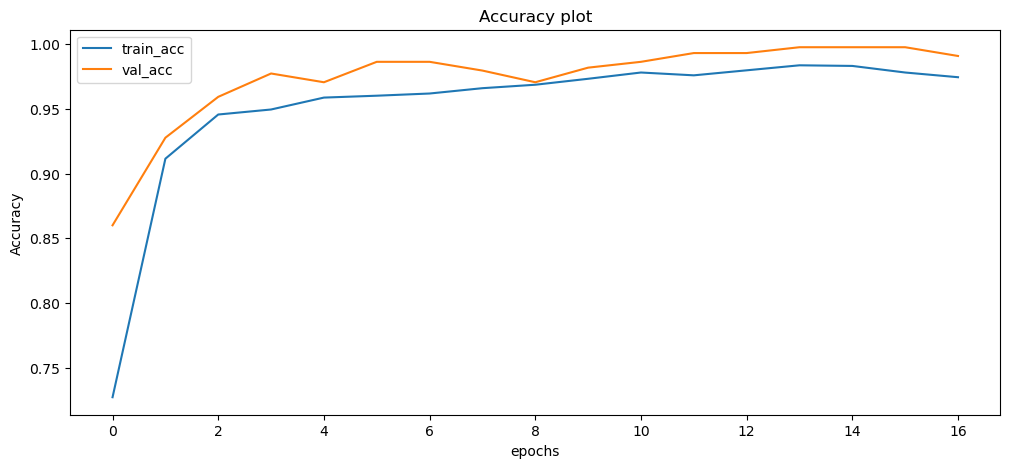

In [65]:
plt.figure(figsize=(12,5))
plt.plot(history.history['acc'], label='train_acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.title('Accuracy plot')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()